In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import INBreast_Dataset
from mc_candidate_proposal.hdog_mc import HDoGCalcificationDetection
import matplotlib.pyplot as plt
import cv2
from math import sqrt
from tqdm import tqdm
import numpy as np

In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        extract_patches=False,
        normalize=None,
        n_jobs=-1,
        partitions=['train']
    )

In [3]:
list_img_idx = list(range(3))

#### Plot functions

In [4]:
def plot_img_rois(index: int, colors = ['yellow','orange'], linewidth = 1,radius = 6):
    """
    Plots the original image with rois as markers. Rectangles for rois with bounding boxes
    and circles with given radius for point lesions. Both markers with given linewidth and colors.

    Args:
        index (int): index of item in the database instance INBreast_Dataset
        colors (list, optional): color of the marker [rectangles, circles]. Defaults to ['yellow','orange'].
        linewidth (int, optional): width of line. Defaults to 1.
        radius (int, optional): radius of circles. Defaults to 6.
    """
    f,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].imshow(db[index]['img'],cmap='gray') # display image
    
    lesion_bbxs = [[bbox[0],bbox[1][0]-bbox[0][0],bbox[1][1]-bbox[0][1]] \
         for bbox in db[index]['lesion_bboxes'] if bbox[0] != bbox[1]] # get lesion boxes

    lesion_pts = [bbox[0] for bbox in db[index]['lesion_bboxes'] if bbox[0] == bbox[1]] # get lesion points
    
    for coords,width,height in lesion_bbxs:
        rec = plt.Rectangle(coords, width=width, height=height, color=colors[0], linewidth=linewidth, fill=False)
        ax[0].add_patch(rec)
    for coords in lesion_pts:
        c = plt.Circle(coords, radius=radius, color=colors[1], linewidth=linewidth, fill=False)
        ax[0].add_patch(c)
    ax[0].set_title('Image with ROIs')
    ax[0].axis('off')
    ax[1].imshow(db[index]['lesion_mask'])
    ax[1].set_title('Image mask')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def easy_plot(i: int):
    """Plots the original image and mask, of instance INBreast_Dataset

    Args:
        i (int): index of item
    """
    f,ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(db[i]['img'], cmap='gray' )
    ax[1].imshow(db[i]['lesion_mask'])
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [6]:
def gaus_plot(i,img_gaus):
    f,ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(db[i]['img'], cmap='gray' )
    ax[1].imshow(img_gaus,cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [7]:
import seaborn as sns

def plot_img_hist(img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(img,cmap='gray')
    sns.histplot(img.flatten(), ax=ax[1], bins=1000, element='poly', alpha=0.2)
    ax[1].set_yscale("log")

In [8]:
def plot_blobs(image,image_blobs):
    f,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(image,cmap='gray')
    for blob in tqdm(image_blobs):
        y,x,r = blob
        c = plt.Circle((x, y), r, color='yellow', linewidth=1, fill=False)
        ax.add_patch(c)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Metric functions

In [9]:
def circle_comparison(true_bboxes, predicted_roi_circles, mask):
    """Finds TP, FP and number of FN for a prediction of circles given image mask

    Args:
        true_bboxes (np.ndarray): Array of shape (n_rois, 2) containing
            tl and br bbox coordinates in tuples
        predicted_roi_circles (np.ndarray): Array of shape (n_predicted_circ, 3)
            with circle_x, circle_y and circle_radius values
        mask (np.ndarray): Image mask containing indexes of rois

    Returns:
        TP (set): contains TP roi indexes
        FP (set): contains FP circle indexes (that weren't mapped to any rois)
        FN (int): number of rois not mapped to any of the predicted circles
    """
    TP = set()
    FP = []

    true_mask = mask

    for circle_idx, circle in enumerate(tqdm(predicted_roi_circles.astype(int))):
        circle_roi_mask=cv2.circle(np.zeros(mask.shape),
                                     (circle[0], circle[1]),
                                     circle[2], 1, -1).astype(np.bool8)

        mapped_rois_idxs=set(
            np.unique(true_mask[circle_roi_mask])).difference(set([0]))
        if len(mapped_rois_idxs) > 0:
            TP = TP.union(mapped_rois_idxs)
        else:
            FP.append(circle_idx)
    FN = len(true_bboxes) - len(TP)
    return TP, FP, FN

In [3]:
def quick_circle_comparison(predicted_roi_circles, mask, return_counts=True):
    """Finds TP, FP and FN among predicted circles based on the true image mask.
    Quick version that checks if a rectangular bbox around each circle in the image
    mask contains any roi indexes and counts a TP if >= 1 roi pixel is in that bbox.
    Args:
        true_bboxes (np.ndarray): Array of shape (n_rois, 2) containing
            top_left and bottom_right bbox coordinates in tuples
        predicted_roi_circles (np.ndarray): Array of shape (n_predicted_circ, 3)
            with circle_x, circle_y and circle_radius values
        mask (np.ndarray): Image mask containing indexes of rois
        return_counts (bool, optional): Whether to return counts of TP, FP, FN arrays
            or corresponding indexes. Defaults to True.
    Returns:
        If return_counts=True:
            (TP, FP, FN) (tuple[int]): number of TP, FP, FN
        else:
            TP (set): contains indexes of ROIs correctly selected by predicted circles
            FP (set): contains indexes of circles that weren't mapped to any roi
            FN (set): indexes of ROIs not mapped to any of the predicted circles
    """
    TP = set()
    FP = []

    # set containing background pixel value in the mask
    back_set = set([0])

    for circle_idx, circle in enumerate(predicted_roi_circles.astype(int)):
        # finds a bbox around each circles and checks if in the mask it contains any rois
        cricle_tl = (max(0, circle[0] - circle[2]),
                     max(0, circle[1] - circle[2]))
        circle_br = (min(mask.shape[1], circle[0] + circle[2]),
                     min(mask.shape[0], circle[1] + circle[2]))

        # looks at pixels in the mask at the circle's bbox
        intersected_mask_idxs = set(
            mask[cricle_tl[1]:circle_br[1], cricle_tl[0]:circle_br[0]].ravel()).difference(back_set)
        if len(intersected_mask_idxs) > 0:
            TP = TP.union(intersected_mask_idxs)
        else:
            FP.append(circle_idx)
    TP = set(TP).difference(back_set)
    FP = set(FP)
    FN = set(mask.ravel()).difference(set([0])).difference(TP)

    if return_counts:
        return (len(TP), len(FP), len(FN))
    else:
        return TP, FP, FN

### Pipe 1

In [4]:
def cal_det_se(no_tp,no_fn):
    return no_tp/(no_tp+no_fn)

def fp_per_unit_area(image_shape,no_fp):
    return no_fp/(image_shape[0] * image_shape[1] * (0.070**2)/100)

In [5]:
import math
def create_binary_mask_from_blobs_a(shape: tuple, blobs_x_y_sigma: list):
    img_binary_blobs = np.zeros(shape)
    for blob in blobs_x_y_sigma:
        img_binary_blobs = cv2.circle(
            img_binary_blobs, (blob[0], blob[1]), int(blob[2] / 2), 255, -1
        )
    return img_binary_blobs

In [5]:
img_list = list(range(len(db))) #np.asarray([i for i in range(db.df.shape[0])])
img_list_sample =  np.random.choice(img_list,size=50,replace=False)
img_list_sample #[ 26,  89, 151, 109,  24,   7,  44, 107,  56, 121]

array([ 26,  89, 151, 109,  24,   7,  44, 107,  56, 121, 139,  85, 136,
        54, 108,  40,  33, 133,  71, 124,  97,   8, 137, 145,  37, 101,
        83,  61,  94,  78,  16,  19, 138,  95,  22,  51, 100,  90,  27,
       106, 105,  45,  18,  60,  30,  93,  59,   2, 122,  43])

In [7]:
#max_sigma = [3,5,7,9]
#divider = [50,100,200,300,500]
# dog_overlap = [0.2,0.4,0.6,0.8]

# Default parameters
dog_parameters = {
    'min_sigma': 1,
    'max_sigma': 3,
    'sigma_ratio': 1.05,
    'n_scales': 20,
    'dog_blob_th': 0.006,
    'dog_overlap': 0.2
}

hessian_parameters = {
    'method': 'eigenval',
    'hessian_threshold': 1.4,
    'hessian_th_divider': 300
}

processed_imgs_path = '/home/acortinau/projects/data_ml/hdog_preprocessed_images'
detections_path = '/home/acortinau/projects/data_ml/hdog_detections'

test_results = []
for idx in tqdm(img_list_sample, total=len(img_list_sample)):
    #for dogov in dog_overlap:
    img_dict = {}
    #hessian_parameters['hessian_th_divider'] = div
    #dog_parameters['dog_overlap'] = dogov
    detector = HDoGCalcificationDetection(dog_parameters, hessian_parameters, processed_imgs_path, detections_path)
    detections, candidate_detections = detector.detect(db[idx]['img'], db.df.at[idx, 'img_id'],use_preprocessed=False,save_results=False)
    img_dict['img_id'] = db.df.at[idx, 'img_id']
    #img_dict['dog_ov'] = dogov
    #img_mask = create_binary_mask_from_blobs_a(db[idx]['img'].shape, detections.astype(int))
    detections = detections.copy()
    detections[:, 2] = detections[:, 2]*sqrt(2)
    #detections[:,[1,0]] = detections[:,[0,1]]
    TP, FP, FN = quick_circle_comparison((detections).astype(int), db[idx]['lesion_mask'])
    img_dict['TP'] = TP
    img_dict['FP'] = FP
    img_dict['FN'] = FN
    img_dict['SE'] = cal_det_se(TP,FN)
    img_dict['FPpua'] = fp_per_unit_area(db[idx]['img'].shape,FP)
    img_dict['No_blobs'] = len(candidate_detections)
    img_dict['No_blobs_fil'] = len(detections)
    # print(f'Img: {idx}, SE: {cal_det_se(TP,FN)},FPpua: {fp_per_unit_area(img_mask.shape,FP)}')
    # print(f'No_blobs: {len(candidate_detections)}, filtered: {len(detections)}')
    test_results.append(img_dict)
    #detector.delete_hdog_file()

100%|██████████| 50/50 [18:58<00:00, 22.76s/it]


In [8]:
import pickle
with open("test9_results.pkl",'wb') as f:
    pickle.dump(test_results,f)
# with open("test1_results.pkl",'rb') as f:
# test = pickle.load(f)

In [1]:
# with open("test3_results.pkl",'rb') as f:
#     test_results = pickle.load(f)

<IPython.core.display.Javascript object>

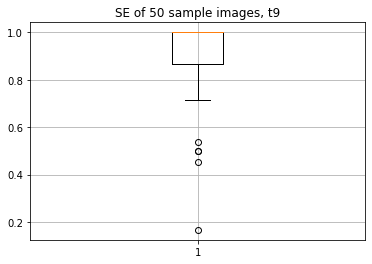

In [13]:
se_values = [ins['SE']for ins in test_results]
#se_values = np.asarray(se_values).reshape(10,4)
se_values = np.asarray(se_values)

plt.boxplot(se_values)
plt.title('SE of 50 sample images, t9')
plt.grid('on')
# plt.xticks(ticks=[1,2,3,4],labels=['0.2','0.4','0.6','0.8'])
# plt.xlabel('dog_overlap')

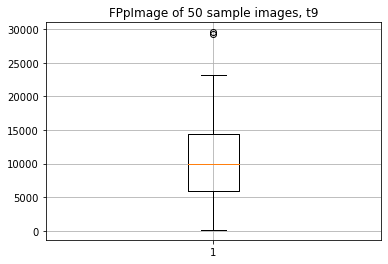

In [14]:
fp_values = [ins['FP']for ins in test_results]
# fp_values = np.asarray(fp_values).reshape(10,4)
fp_values = np.asarray(fp_values)
plt.boxplot(fp_values)
plt.title('FPpImage of 50 sample images, t9')
plt.grid('on')
# plt.xticks(ticks=[1,2,3,4],labels=['0.2','0.4','0.6','0.8'])
# plt.xlabel('dog_overlap')

In [14]:
print(test_results[0]['FP'],test_results[1]['FP'],test_results[2]['FP'])

207701 147180 121620


In [15]:
img_list_sample.astype(np.str)

/tmp/ipykernel_16379/1667015728.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_list_sample.astype(np.str)


array(['26', '89', '151', '109', '24', '7', '44', '107', '56', '121'],
      dtype='<U21')

In [18]:
[range(10)]

[range(0, 10)]

/tmp/ipykernel_16379/2775706332.py:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xticks(ticks=list(range(10)),labels=img_list_sample.astype(np.str))


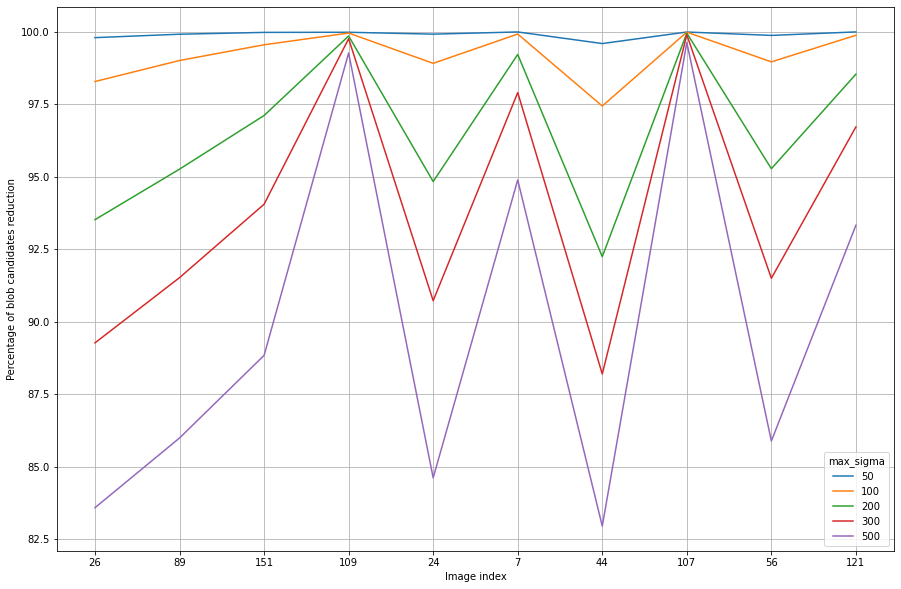

In [22]:
no_blobs = [ins['No_blobs']for ins in test_results]
no_blobs_fil = [ins['No_blobs_fil']for ins in test_results]
blobs_arr = np.asarray(list(zip(no_blobs,no_blobs_fil)))

blob_reduc_perc = 100*((blobs_arr[:,0]-blobs_arr[:,1])/blobs_arr[:,0]).reshape(10,5)
plt.figure(figsize=(15,10))
plt.plot(blob_reduc_perc)
plt.legend(divider,title='max_sigma')
plt.ylabel('Percentage of blob candidates reduction')
plt.xlabel('Image index')
plt.xticks(ticks=list(range(10)),labels=img_list_sample.astype(np.str))
plt.grid('on')
plt.show()

Text(0.5, 0, 'Image number')

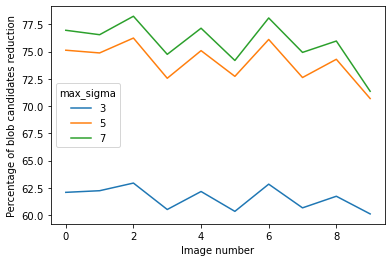

In [39]:
blob_reduc_perc = 100*((blobs_arr[:,0]-blobs_arr[:,1])/blobs_arr[:,0]).reshape(10,3)
plt.figure()
plt.plot(blob_reduc_perc)
plt.legend([3,5,7],title='max_sigma')
plt.ylabel('Percentage of blob candidates reduction')
plt.xlabel('Image index')


In [16]:
import h5py
path = '/home/jseia/Desktop/ml-dl/data/hdog_detections/det_ms-1.18_sr-1.05_Ms-3.1_m-marasinou_dth-0.006_hdiv-200.0_hth-1.14.hdf5'
with h5py.File(path, 'r') as f:
    raw_detections = f[f'{db.df.at[idx, "img_id"]}/hessian_detections'][:]

In [9]:
# plot_img_hist(db[3]['img'])
# plot_img_hist(img_mask)

### Test run of images subset

In [8]:
# # img_list = np.asarray([i for i in range(db.df.shape[0])])
# # img_list_sample =  np.random.choice(img_list,size=30,replace=False)
# img_list_sample = np.asarray([
#        111, 175,  12, 218, 205,  74, 210, 173, 189, 216,  73,  15, 258,
#        106,  22, 226, 252, 135, 234, 290,  64, 152, 239, 201,  89,  52,
#        122, 248, 280,  63
# ])


In [1]:
# list_imgs = [] 
# for img_idx in tqdm(img_list_sample,total=img_list_sample.shape[0]):
#     imgs_binary_blobs = {}
#     img_mask,blob_list,no_blobs,no_blobs_filtered = get_image_blobs_2(db[img_idx]['img'])
#     imgs_binary_blobs['img_index'] = img_idx
#     blob_list_arr = np.array(blob_list.copy())
#     blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
#     blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]
#     TP, FP, FN = quick_circle_comparison(db[img_idx]['lesion_bboxes'],(blob_list_arr).astype(int),db[img_idx]['lesion_mask'])
    
#     pred_se = cal_det_se(len(TP),FN)
#     print(f'Sensitivity of image {img_idx}: {pred_se}')
#     fp_pua = fp_per_unit_area(img_mask.shape,FP)
#     print(f'FP per unit area (sqr cm): {fp_pua}')
    
#     imgs_binary_blobs['Sensitivity'] = pred_se
#     imgs_binary_blobs['FP_pua'] = fp_pua
#     imgs_binary_blobs['No_blobs'] = no_blobs
#     imgs_binary_blobs['No_filtered_blobs'] = no_blobs_filtered
#     list_imgs.append(imgs_binary_blobs)


# # Default parameters
# dog_parameters = {
#     'min_sigma': 1.18,
#     'max_sigma': 3.1,
#     'sigma_ratio': 1.05,
#     'n_scales': None,
#     'dog_blob_th': 0.006,
#     'dog_overlap': 1
# }

# hessian_parameters = {
#     'method': 'marasinou',
#     'hessian_threshold': 1.4,
#     'hessian_th_divider': 200.
# }

# processed_imgs_path = '/home/jseia/Desktop/ml-dl/data/hdog_preprocessed_images'
# detections_path = '/home/jseia/Desktop/ml-dl/data/hdog_detections'

# for idx in (range(1, 4)):
#     for h_thr in h_thr_list:
#         hessian_parameters['hessian_threshold'] = h_thr
#         detector = HDoGCalcificationDetection(dog_parameters, hessian_parameters, processed_imgs_path, detections_path)
#         detections, candidate_detections = detector.detect(db[idx]['img'], db.df.at[idx, 'img_id'])
        
#         img_mask = create_binary_mask_from_blobs(db[idx]['img'].shape, detections.astype(int))
#         detections = detections.copy()
#         detections[:, 2] = detections[:, 2]*sqrt(2)
#         TP, FP, FN = quick_circle_comparison(
#             db[idx]['lesion_bboxes'], (detections).astype(int), db[idx]['lesion_mask']
#         )
#         print(f'Img: {idx}, h_thr: {h_thr} SE: {cal_det_se(len(TP),FN)},FPpua: {fp_per_unit_area(img_mask.shape,FP)}')
#         print(f'    No_blobs: {len(detections)}, filtered: {len(candidate_detections)}')
#     detector.delete_hdog_file()


In [7]:
# se_values = [ins['Sensitivity']for ins in list_imgs]
# plt.boxplot(se_values)
# plt.title('Sensitivity of 30 samples')
# plt.grid('on')

In [6]:
# print(np.asarray(se_values).mean())
# print(np.asarray(se_values).std())

In [5]:
# #fp_values = [30.909901284623576, 10.394047736381305,74.53340210271118,4.683384256286333,1.9745396263295723,3.4205948119680607,23.121054198602593,0.858674514666902,13.590545289117077,4.548411690608931,11.44532675171463,0.7802536954658975,8.896454882951506,1.6205186178142958,5.1301042633063005,4.4459818382810194,31.862220640220453,1.528085390293803,3.9626919300853216,56.922418975116756,74.89201789237066,7.83489492062152,27.935772460361054,12.111962100020257,11.594564969328971,22.73265521421926,5.820922509759327,0.36262608735698704,16.280833219844524,8.264114117760382]
# fp_values = [ins['FP_pua']for ins in list_imgs]
# plt.boxplot(fp_values)
# plt.title('FP per unit area (sqr cm) of 30 samples')
# plt.grid('on')

In [37]:
list_imgs[0]

{'img_index': 111,
 'Sensitivity': 0.875,
 'FP_pua': 0.875,
 'No_blobs': 125234,
 'No_filtered_blobs': 8058}

In [3]:
# for im_index,image_results in enumerate(list_imgs):
#     no_fp = image_results['FP']
#     no_tp = len(image_results['TP'])
#     no_fn = image_results['FN']
#     print(f'Sensitivity of image {im_index}: {cal_det_se(no_tp,no_fn)}')
#     fp_pua = fp_per_unit_area(image_results['img_mask'].shape,no_fp)
#     print(f'FP per unit area (sqr cm): {fp_pua}')

In [2]:
# list_imgs = [] 
# for img_idx in range(10):
#     imgs_binary_blobs = {}
#     img_mask,blob_list = get_image_blobs(list_img[img_idx],hess_fil_type=2)
#     imgs_binary_blobs['img_mask'] = img_mask
#     imgs_binary_blobs['blobs_coords'] = blob_list
    
#     blob_list_arr = np.array(blob_list.copy())
#     blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
#     blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]
#     TP, FP, FN = quick_circle_comparison(db[img_idx]['lesion_bboxes'],(blob_list_arr).astype(int),db[img_idx]['lesion_mask'])
#     imgs_binary_blobs['TP'] = TP
#     imgs_binary_blobs['FP'] = FP
#     imgs_binary_blobs['FN'] = FN
#     list_imgs.append(imgs_binary_blobs)

In [4]:
# for im_index,image_results in enumerate(list_imgs):
#     no_fp = image_results['FP']
#     no_tp = len(image_results['TP'])
#     no_fn = image_results['FN']
#     print(f'Sensitivity of image {im_index}: {cal_det_se(no_tp,no_fn)}')
#     fp_pua = fp_per_unit_area(image_results['img_mask'].shape,no_fp)
#     print(f'FP per unit area (sqr cm): {fp_pua}')